In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, auc

In [123]:
"""
    read_data(cof, gas, carrier, ppm)

read in the sensor response data for a given COF exposed to a 
given gas with a given carrier at a given concentration.
returns list of pandas data frames with this data. (may be replicates)
each data frame has two columns: time, DeltaG/G0.
"""
def read_data(cof, gas, carrier, ppm):
    # get path to appropriate file
    path = Path.cwd().joinpath("Raw_sensing_data", gas, cof, carrier,).rglob("*.xlsx")

    # some folders contain multiple excel files, so create a list
    files = [file for file in path]
        
    # extract data from Excel files in list
    dfs = []
    for filename in files:
        # CASE 1: all replicates in a single file.
        if len(files) == 1:
            df = pd.read_excel(filename, header=6,
                               names=['time', 'rep0 DeltaG/G0', 'rep1 DeltaG/G0', 'rep2 DeltaG/G0', 'rep3 DeltaG/G0'],
                               usecols="B,D,H,L,P"
                              )
            # exposure time begins at 750s
            # exposure time ends 2580s later (3330s)
            df = df.iloc[1499:6660]
            assert df.iloc[0]["time"] == 750.0
            assert df.iloc[-1]["time"] == 3330.0

            # reshift time
            df["time"] = df["time"] - 750.0

            df.reset_index(drop=True, inplace=True)

            for i in range(4):
                # column we want.
                col = 'rep{} DeltaG/G0'.format(i)
                data_rep = df[['time', col]]
                data_rep = data_rep.rename(columns={col: "DeltaG/G0"})
                # only append if not all 100's (corresponding to replicate missing.)
                if not np.all(data_rep['DeltaG/G0'] == 100.0):
                    dfs.append(data_rep)
        # CASE 2: all replicates in a separate file.
        else:
            # TODO: alt. read-in
            dfs.append(df)
         # TODO: amalgamate these into df.       
    return dfs

In [124]:
data = read_data("Co-COF-DC-8", "CO", "air_dry", 80)
data

[        time  DeltaG/G0
 0        0.0   0.017653
 1        0.5   0.000000
 2        1.0   0.017653
 3        1.5   0.000000
 4        2.0   0.017653
 ...      ...        ...
 5156  2578.0   3.452213
 5157  2578.5   3.452213
 5158  2579.0   3.470150
 5159  2579.5   3.470150
 5160  2580.0   3.470150
 
 [5161 rows x 2 columns]]

In [110]:
data = read_data("Cu-COF-DC-8", "H2S", "air_humid", 80)
data

[        time  DeltaG/G0
 0      750.0   0.000000
 1      750.5   0.000000
 2      751.0  -0.217382
 3      751.5   0.000000
 4      752.0  -0.217382
 ...      ...        ...
 5156  3328.0  89.236542
 5157  3328.5  89.247393
 5158  3329.0  89.253904
 5159  3329.5  89.228954
 5160  3330.0  89.224613
 
 [5161 rows x 2 columns],
         time  DeltaG/G0
 0      750.0  -0.064974
 1      750.5   0.000000
 2      751.0  -0.043201
 3      751.5   0.237430
 4      752.0   0.129602
 ...      ...        ...
 5156  3328.0  99.015552
 5157  3328.5  99.019223
 5158  3329.0  99.017495
 5159  3329.5  99.022464
 5160  3330.0  99.023543
 
 [5161 rows x 2 columns],
         time  DeltaG/G0
 0      750.0   0.140033
 1      750.5   0.419539
 2      751.0   0.489331
 3      751.5   0.279730
 4      752.0   0.140033
 ...      ...        ...
 5156  3328.0  98.150651
 5157  3328.5  98.145059
 5158  3329.0  98.149947
 5159  3329.5  98.147151
 5160  3330.0  98.147151
 
 [5161 rows x 2 columns],
         time  D

In [111]:
data[0]

,time,DeltaG/G0
0,750.0,0.000000
1,750.5,0.000000
2,751.0,-0.217382
3,751.5,0.000000
4,752.0,-0.217382
...,...,...
5156,3328.0,89.236542
5157,3328.5,89.247393
5158,3329.0,89.253904
5159,3329.5,89.228954


In [48]:
# function to do linear regression on a single partition of data
    # input: partition of time & each DeltaG/G0, j := which DeltaG/G0 column (1,2,3, or 4) 
    # output: linear regression coefficients and mean squared errors
def lin_reg(df,j):
    X = df.loc[:,"time"].to_numpy().reshape(-1,1)
    Y = df.loc[:,'GB'+str(j)+" DeltaG/G0"].to_numpy().reshape(-1,1)
    reg = LinearRegression().fit(X,Y)
    y_fit = reg.predict(X)
    mse = mean_squared_error(Y,y_fit)

    coef = reg.coef_.tolist().pop().pop()

    #print("coef from lin_reg function: ",coef)

    return [coef,mse,X,Y,y_fit]

In [159]:
class SensorResponse:
    def __init__(self, cof, gas, carrier_gas, ppm, replicate_id):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm
    
        self.data = read_data(cof, gas, carrier_gas, ppm)[replicate_id]
        
    # """
    # estimate initial slope of data.

    # # arguments:
    # * partition_size := size of the time window for partitions (ex: 30sec)
    # * total_time_window := the total time after introduction of substance
    # * considered to compute intial slope (ex: 1000s)
    # * k := which element of the self.data, default k=0
    # * mse_bound := bound on acceptable mean squared error for initial slope linear regression
    # """
    # def compute_initial_slope(self, partition_size=72, total_time_window=600, k=0, mse_bound=1):
    #     initial_slopes = []
    #     n_partitions = int(total_time_window/partition_size)
    #     partitions = []
    #     #partition the data
    #     for i in range(n_partitions):
    #         partitions.append(self.data[k].iloc[i*partition_size:(i+1)*partition_size])
        
    #     # data for plots
    #     Yregs = [] #regression data
    #     Ys = [] #data from initial slope partition
    #     Xs = []
    #     # perform linear regression on partitions and append (coefficient, MSE) pairs
    #     # to slopes_mse
    #     for j in range(1,5):
    #         slopes_mse = []
    #         for df in partitions:
    #             regdata = lin_reg(df,j)
                
    #             # condition on mean squared error: only include data if MSE is small enough
    #             if regdata[1] < mse_bound:
    #                 slopes_mse.append(regdata)

                
    #         if bool(slopes_mse) == 0:
    #             print("GB"+str(j)+"DeltaG/G0 has no initial slopes that satisfy mse bound. ")        
    #         # take initial slope to be the max of the linear regression slopes which satisfy the MSE condition
    #         #print(slopes_mse)
    #         slope_msedf = pd.DataFrame(slopes_mse)
    #         #print("slope_msedf: ", slope_msedf)
    #         initial_slopeloc = slope_msedf[0].abs().idxmax()
    #         #print("initial_slopeloc: ",initial_slopeloc)
    #         initial_slope = slope_msedf[0].abs().max()
    #         initial_slopes.append(initial_slope)

    #         #plot entire time series of exposure
    #         #axes = self.data[k].plot(x='time',y='GB'+str(j)+' DeltaG/G0') 
    #         #plot initial slope on top of entire time series data
    #         #axes.plot(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[4].iloc[initial_slopeloc],color="orange")      
    #         #store data for visualization/plots
    #         Xs.append(slope_msedf[2].iloc[initial_slopeloc])
    #         Yregs.append(slope_msedf[4].iloc[initial_slopeloc])
    #         Ys.append(slope_msedf[3].iloc[initial_slopeloc])
             
    #         #plot just the linear regression on top of partition data
    #         #fig, ax = plt.subplots()
    #         #scatter = ax.scatter(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[3].iloc[initial_slopeloc])
            
    #         #ax.plot(slope_msedf[2].iloc[initial_slopeloc],slope_msedf[4].iloc[initial_slopeloc],color="orange")

    #     return [initial_slopes,Xs,Yregs,Ys]

    def compute_saturation(self, n_partitions=100):
        ids_splits = np.array_split(self.data.index, n_partitions)

        # get mean over partitions
        means = [np.mean(self.data.iloc[ids_split]['DeltaG/G0']) for ids_split in ids_splits]

        id_max_magnitude = np.argmax(np.abs(means))
        
        return means[id_max_magnitude]
    
    #compute area under curve for each GBx DeltaG/G0 using sklearn auc
    # def compute_area(self,k=0):
    #     X = self.data[k].loc[:,'time'].to_numpy().reshape(-1,1)
    #     Y1 = self.data[k].loc[:,'GB1 DeltaG/G0'].to_numpy().reshape(-1,1)
    #     Y2 = self.data[k].loc[:,'GB2 DeltaG/G0'].to_numpy().reshape(-1,1)
    #     Y3 = self.data[k].loc[:,'GB3 DeltaG/G0'].to_numpy().reshape(-1,1)
    #     Y4 = self.data[k].loc[:,'GB4 DeltaG/G0'].to_numpy().reshape(-1,1)

    #     areas = [auc(X,Y1),auc(X,Y2),auc(X,Y3),auc(X,Y4)]
    #     return areas
    
    def viz(self, save=False): # viz the data along with the response features or function u fit to it.
        # plotdata = self.compute_initial_slope()
        # sat = self.compute_saturation()
        fig, ax = plt.subplots()
        plt.scatter(self.data['time'], self.data['DeltaG/G0'])
        plt.xlabel("time [s]")
        plt.ylabel("$\Delta G/G_0$")
        plt.show()
            # #full time series plot with initial slope partition
            # axes = self.data[k].plot(x='time',y='GB'+str(j+1)+' DeltaG/G0')
            # axes.plot(plotdata[1][j],plotdata[2][j])
            # axes.axhline(sat[j],color='green',linestyle='dashed')
            # #just initial slope linear regression
           
            # scatter = ax.scatter(plotdata[1][j],plotdata[3][j])
            # ax.plot(plotdata[1][j],plotdata[2][j],color="orange")

    # def vector_representation(self,docnum=0): # returns the vector characterizing the response.
    #     response = []
    #     response.append(self.compute_initial_slope(k=docnum)[0])
    #     response.append(self.compute_saturation(k=docnum))
    #     response.append(self.compute_area(k=docnum))
    #     return response

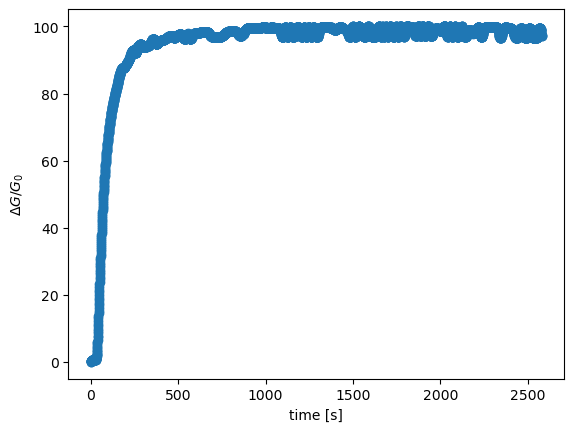

In [160]:
# Test the SensorResponse class initial_slope function
sensor_response = SensorResponse("Cu-COF-DC-8", "H2S", "air_dry", 80, 1)
sensor_response.viz()

In [162]:
sensor_response.compute_saturation()

99.92244851071219

In [145]:
np.array_split(sensor_response.data.index, 3)

[Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720],
            dtype='int64', length=1721),
 Int64Index([1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730,
             ...
             3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440],
            dtype='int64', length=1720),
 Int64Index([3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450,
             ...
             5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160],
            dtype='int64', length=1720)]

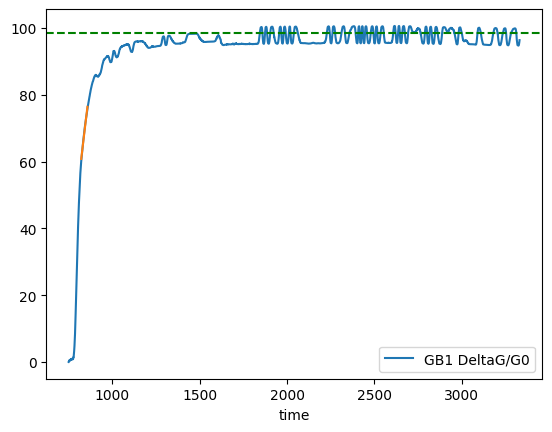

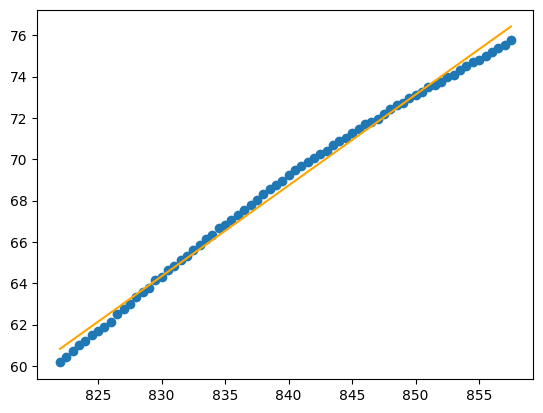

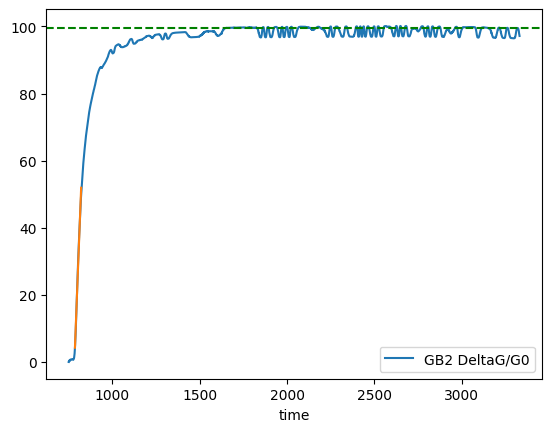

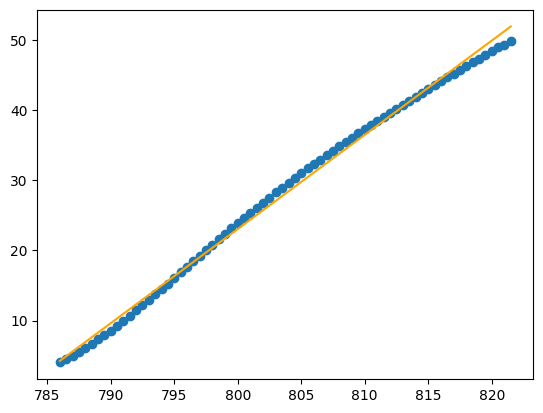

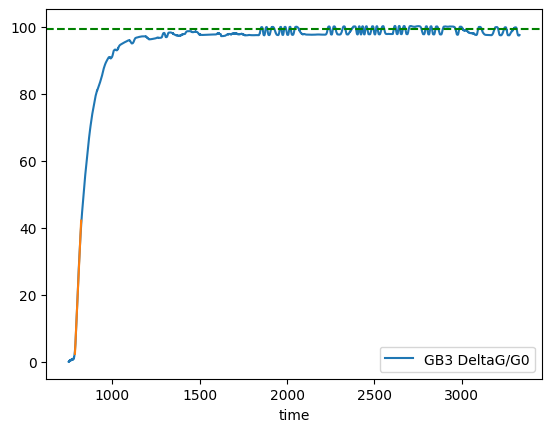

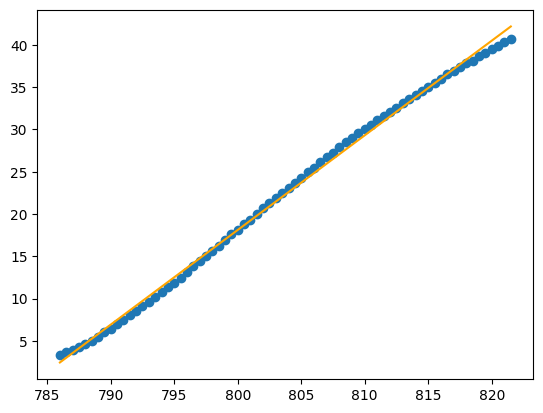

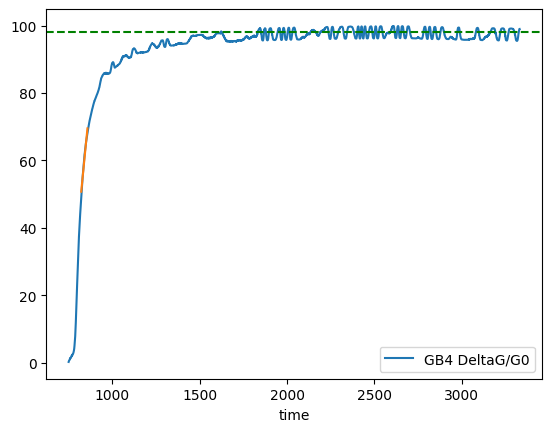

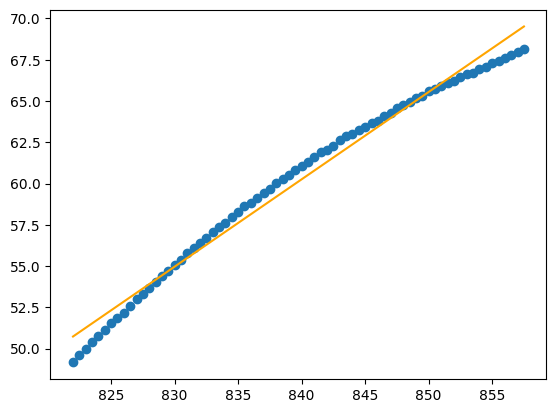

In [51]:
test.viz()

In [52]:
print(test.compute_initial_slope(20,600,0,0.1)[0])
print(test.compute_saturation())
print(test.compute_area())

[1.9361849675693334, 1.5482583343604446, 1.2051431400306394, 1.4838288917660671]
[98.56822400886834, 99.62978386578861, 99.40344396050958, 98.17446517362984]
[241723.8886419699, 244152.272025501, 243007.23352050892, 239705.57772069253]


In [53]:
print(test.vector_representation())

[[0.4392201924419994, 1.3430418427765265, 1.1194797316220995, 0.5289642577599905], [98.56822400886834, 99.62978386578861, 99.40344396050958, 98.17446517362984], [241723.8886419699, 244152.272025501, 243007.23352050892, 239705.57772069253]]


In [54]:
test2 = SensorResponse("Cu-COF-DC-8","NH3","air_humid",80)

In [55]:
print(test2.compute_initial_slope()[0])
print(test2.compute_saturation())
print(test2.compute_area())


[0.5146028187993581, 0.4502340714437489, 0.0, 0.0]
[65.30217906998811, 52.71640927978379, 100.0, 100.0]
[143523.8119352084, 115758.26203188971, 258000.0, 258000.0]


In [56]:
print(test2.vector_representation())

[[0.5146028187993581, 0.4502340714437489, 0.0, 0.0], [65.30217906998811, 52.71640927978379, 100.0, 100.0], [143523.8119352084, 115758.26203188971, 258000.0, 258000.0]]


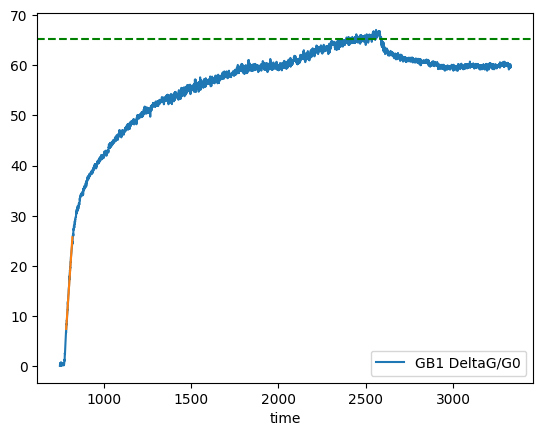

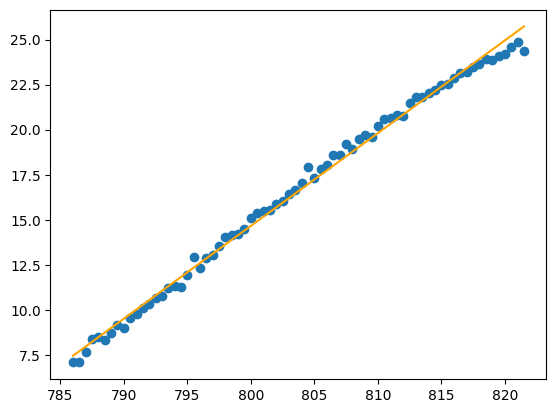

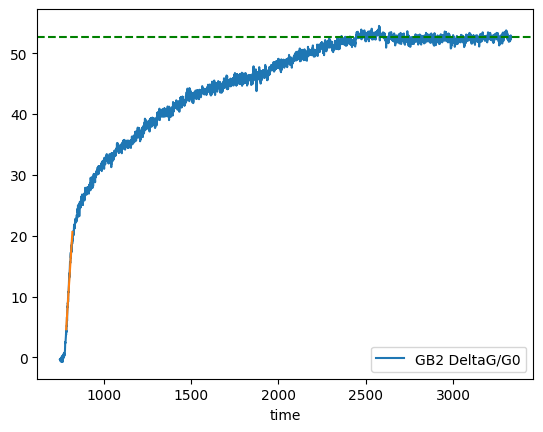

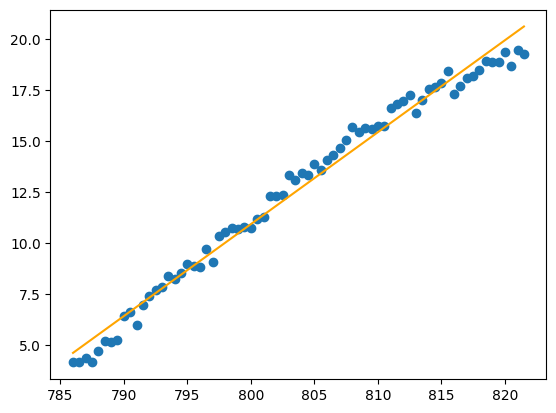

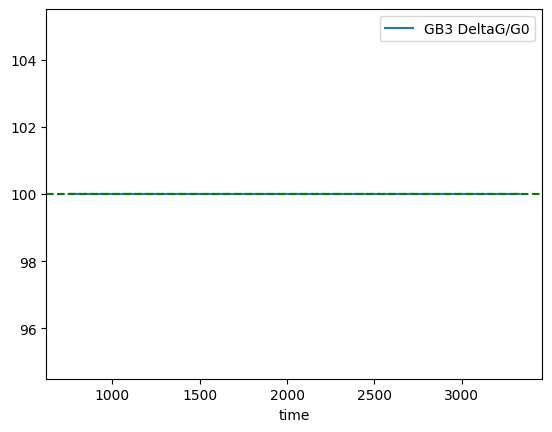

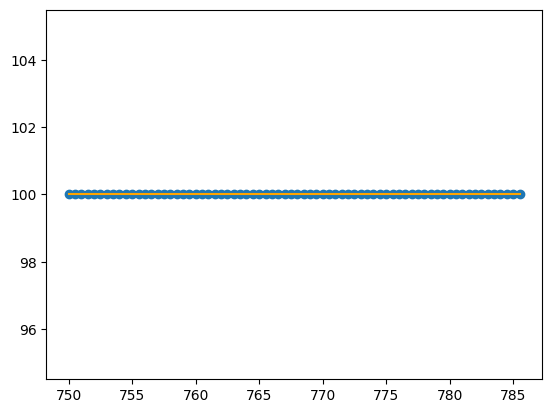

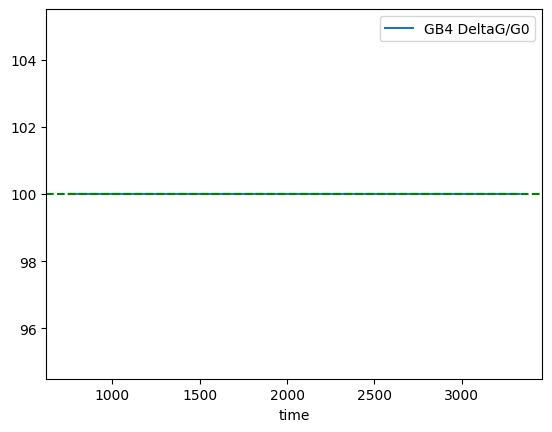

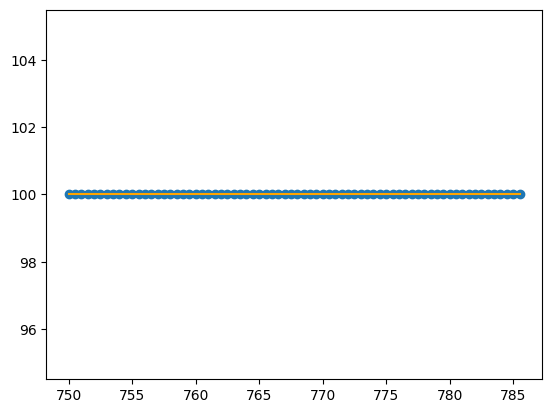

In [57]:
test2.viz()

In [58]:
test3 = SensorResponse("Co-COF-DC-8","NH3","air_dry",80)

[[0.1403905363598618, 0.11854736836344731, 0.22305019135829915, 0.17223453040267767], [33.93481926319436, 30.713947700145944, 41.83887502439708, 37.63004886826016], [60568.30496689379, 52393.08446885612, 78917.74553888658, 68161.19706790437]]


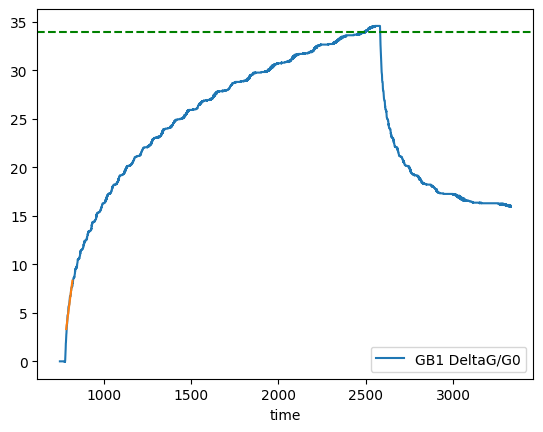

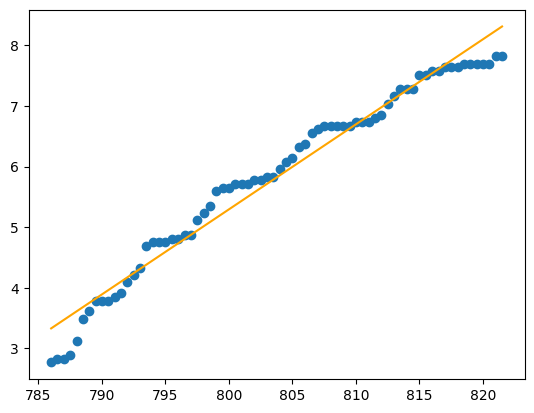

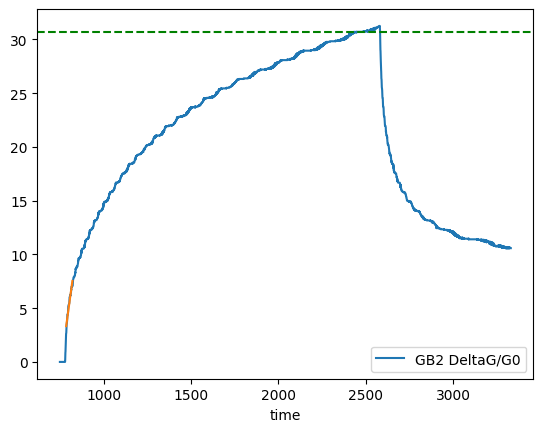

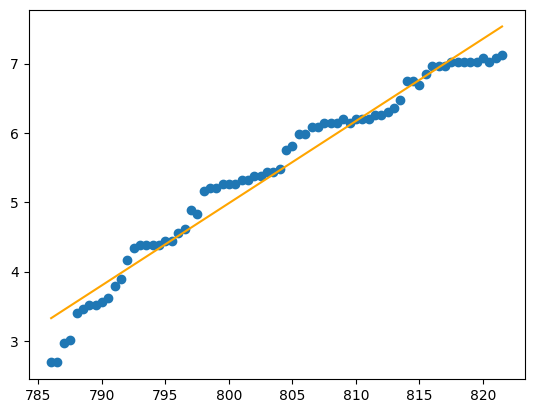

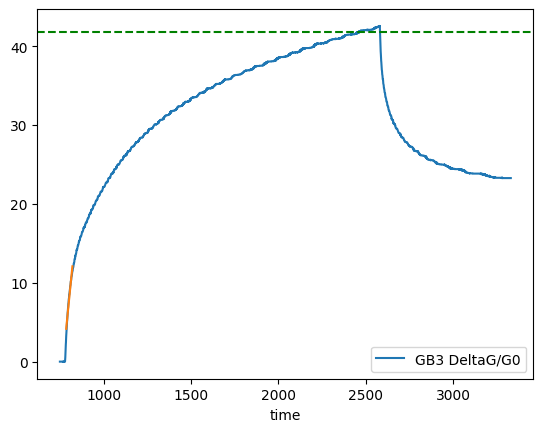

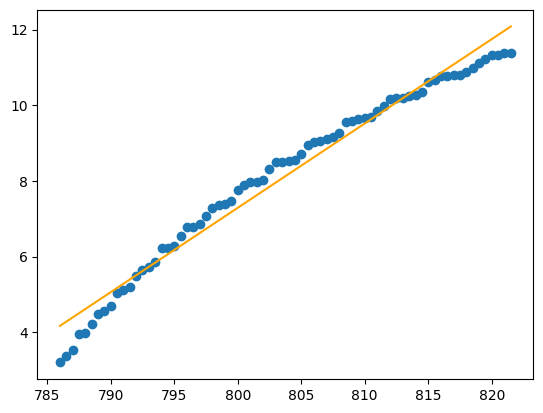

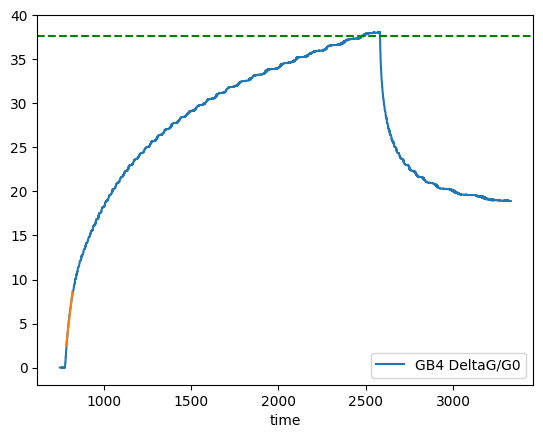

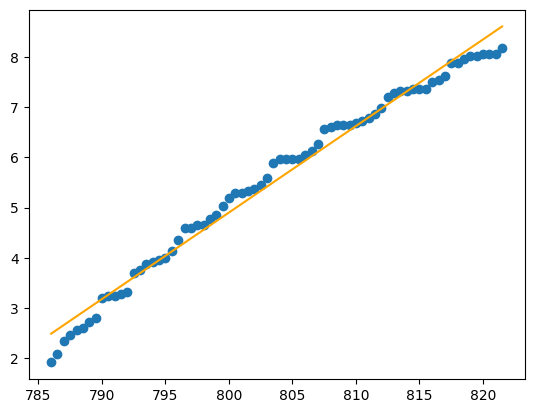

In [59]:
print(test3.vector_representation())
test3.viz()

In [60]:
test4 = SensorResponse("Co-COF-DC-8","NO","air_dry",80)

[[1.3065132295852573, 1.5409178228161564, 1.2308772238709558, 0.0], [-183.20928518122406, -255.0613768923525, -178.97288218914343, 100.0], [-403546.2003406406, -549183.0763421704, -389965.97295681835, 258000.0]]


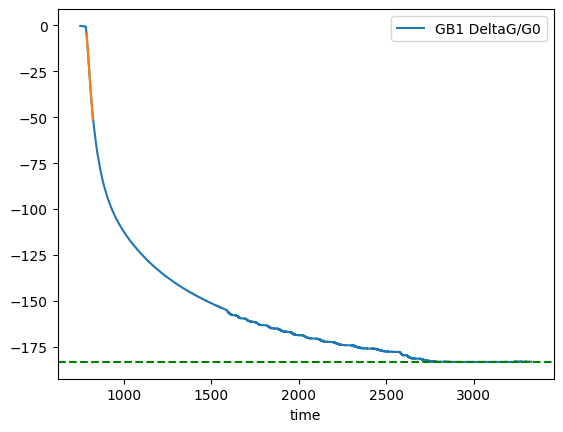

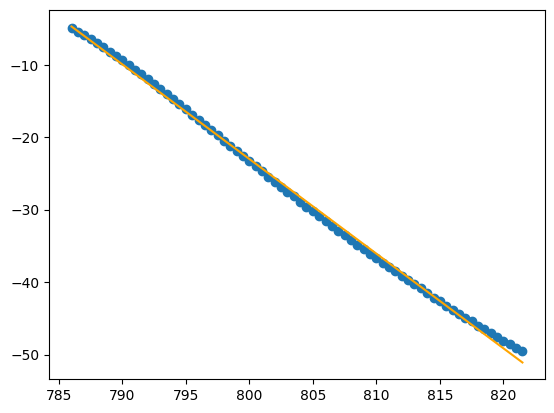

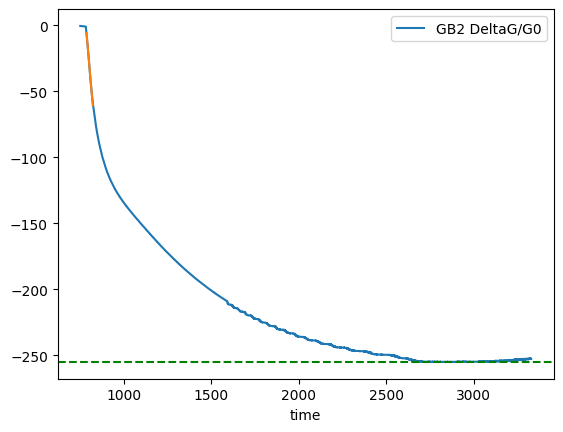

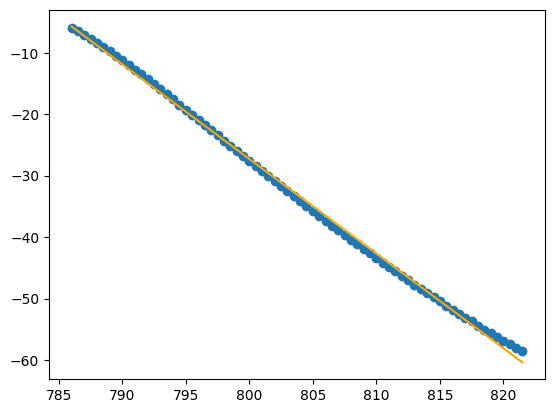

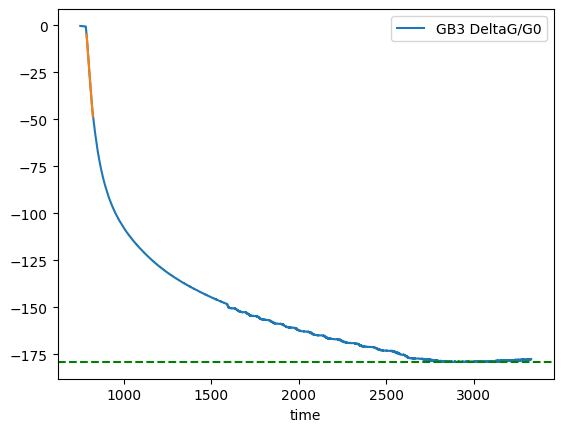

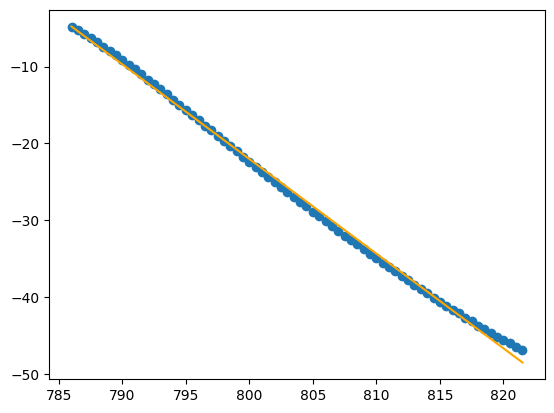

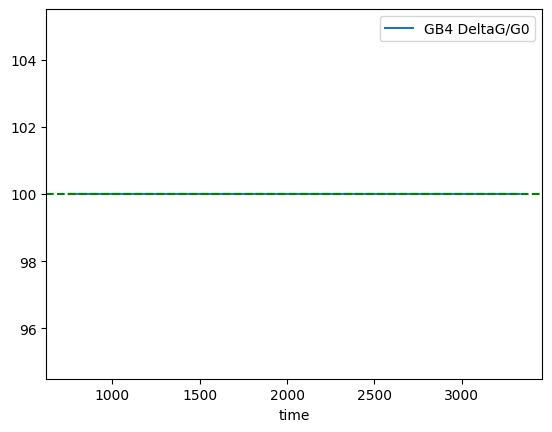

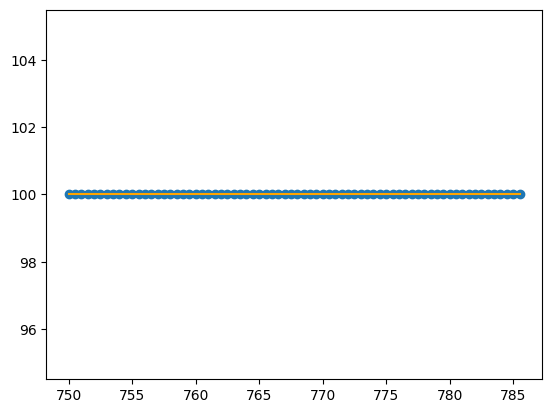

In [61]:
print(test4.vector_representation())
test4.viz()